In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jcm.model import SpeedyModel
from jcm.params import Parameters

def make_ones_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(1.0)):
    return jtu.tree_map(lambda x: jnp.ones_like(x), state)

def make_zeros_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(0.0)):
    zero_state = jtu.tree_map(lambda x: jnp.zeros_like(x), state)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 10:25, 10:25].set(1.0)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 15:20, 15:20].add(1.0)
    return zero_state
    
def make_zeros_parameters_object(params):
    def make_tangent(x):
        if jnp.issubdtype(jnp.result_type(x), jnp.bool_):
            return np.zeros((), dtype=jax.dtypes.float0)
        elif jnp.issubdtype(jnp.result_type(x), jnp.integer):
            return np.zeros((), dtype=jax.dtypes.float0)
        else:
            return jnp.zeros_like(x)
    return jtu.tree_map(lambda x: make_tangent(x), params)

def make_ones_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.ones_like(x), predictions)

def make_zeros_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.zeros_like(x), predictions)

In [94]:
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", True) # some physics fields might be nan
model = SpeedyModel(
    time_step=30,
    save_interval=1,
    total_time=6,
    layers=8,
    boundary_file='/home/jvm/su24/jax-gcm/jcm/data/bc/t30/clim/boundaries_daily.nc'
)
state = model.get_initial_state()
params = Parameters.default()

In [95]:
zero_state, zero_params = make_zeros_dinosaur_StateWithTime_object(state), make_zeros_parameters_object(params)
# zero_params.surface_flux.cds = jnp.array(1.)
# zero_params.mod_radcon.emisfc = jnp.array(1.)
zero_params.mod_radcon.albsea = jnp.array(1.)

tangent = (zero_state, zero_params)
y, jvp_at_x = jax.jvp(model.unroll, (state, params), tangent)

In [41]:
# (final_state, predictions), vjp_fn = jax.vjp(model.unroll, state)

In [42]:
# cotangent = (
#     make_zeros_dinosaur_StateWithTime_object(final_state),
#     make_zeros_prediction_object(predictions)
# )
# grad_state = vjp_fn(cotangent)

In [96]:
grad_ds = model.predictions_to_xarray(jvp_at_x[1])
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 23.7MB


/home/jvm/su24/jax-gcm/jcm/model.py:303: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  pred_ds['time'] = (self.start_date.delta.days + pred_ds.time).astype('datetime64[D]')


In [84]:
print(list(grad_ds.variables))

['surface_flux.ustr.2', 'surface_flux.shf.0', 'shortwave_rad.ftop', 'convection.se', 'longwave_rad.ftop', 'mod_radcon.ablco2', 'shortwave_rad.ssr', 'mod_radcon.alb_s', 'mod_radcon.snowc', 'mod_radcon.tau2.1', 'condensation.dqlsc', 'shortwave_rad.dfabs', 'longwave_rad.dfabs', 'mod_radcon.albsfc', 'surface_flux.tskin', 'shortwave_rad.qcloud', 'shortwave_rad.rsds', 'mod_radcon.alb_l', 'shortwave_rad.fsol', 'mod_radcon.tau2.3', 'surface_flux.ustr.0', 'surface_flux.evap.1', 'temperature', 'surface_flux.ustr.1', 'humidity.qsat', 'surface_flux.v0', 'surface_flux.evap.2', 'surface_flux.slru.1', 'surface_flux.slru.0', 'shortwave_rad.gse', 'surface_flux.vstr.1', 'surface_flux.vstr.2', 'land_model.stl_am', 'mod_radcon.stratc.0', 'shortwave_rad.zenit', 'convection.iptop', 'surface_flux.shf.1', 'surface_flux.hfluxn.1', 'surface_flux.evap.0', 'convection.psa', 'condensation.dtlsc', 'mod_radcon.flux.1', 'condensation.precls', 'date.model_year', 'mod_radcon.st4a.0', 'surface_flux.u0', 'mod_radcon.st4a

gradient of mod_radcon.alb_s is 1.0
gradient of mod_radcon.snowc is -0.0
gradient of condensation.dqlsc is 0.0
gradient of mod_radcon.alb_l is 0.0
gradient of shortwave_rad.fsol is 0.0
gradient of surface_flux.slru.1 is 0.0
gradient of land_model.stl_am is 0.0
gradient of shortwave_rad.zenit is -0.0
gradient of condensation.dtlsc is 0.0
gradient of condensation.precls is 0.0
gradient of mod_radcon.flux.2 is 0.0
gradient of convection.precnv is 0.0
gradient of land_model.stl_lm is 0.0
gradient of shortwave_rad.cloudc is 0.0
gradient of longwave_rad.slr is 0.0
gradient of mod_radcon.flux.3 is 0.0
gradient of shortwave_rad.ozone is 0.0
gradient of convection.cbmf is 0.0
gradient of shortwave_rad.stratz is -0.0
gradient of surface_flux.tsfc is 0.0
gradient of shortwave_rad.ozupp is 0.0


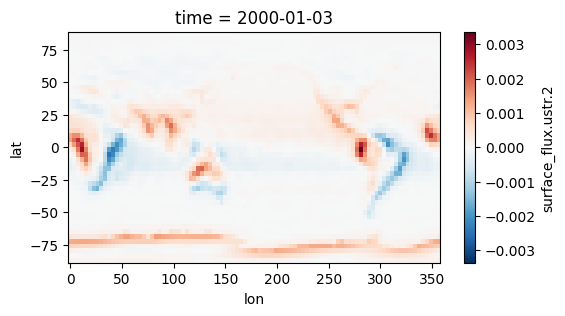

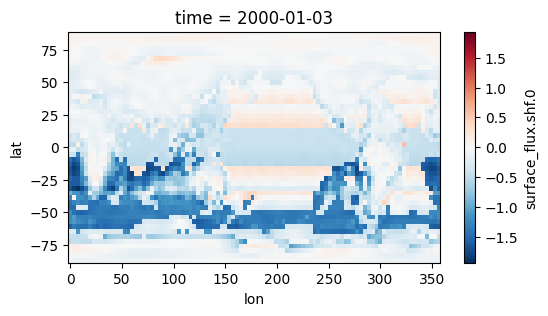

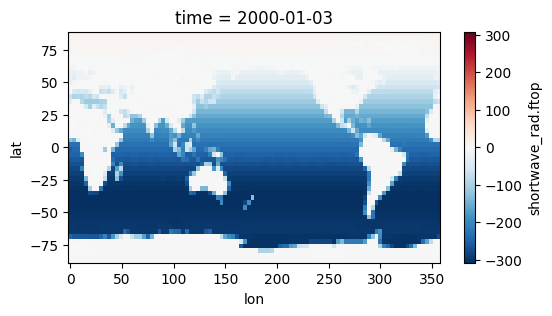

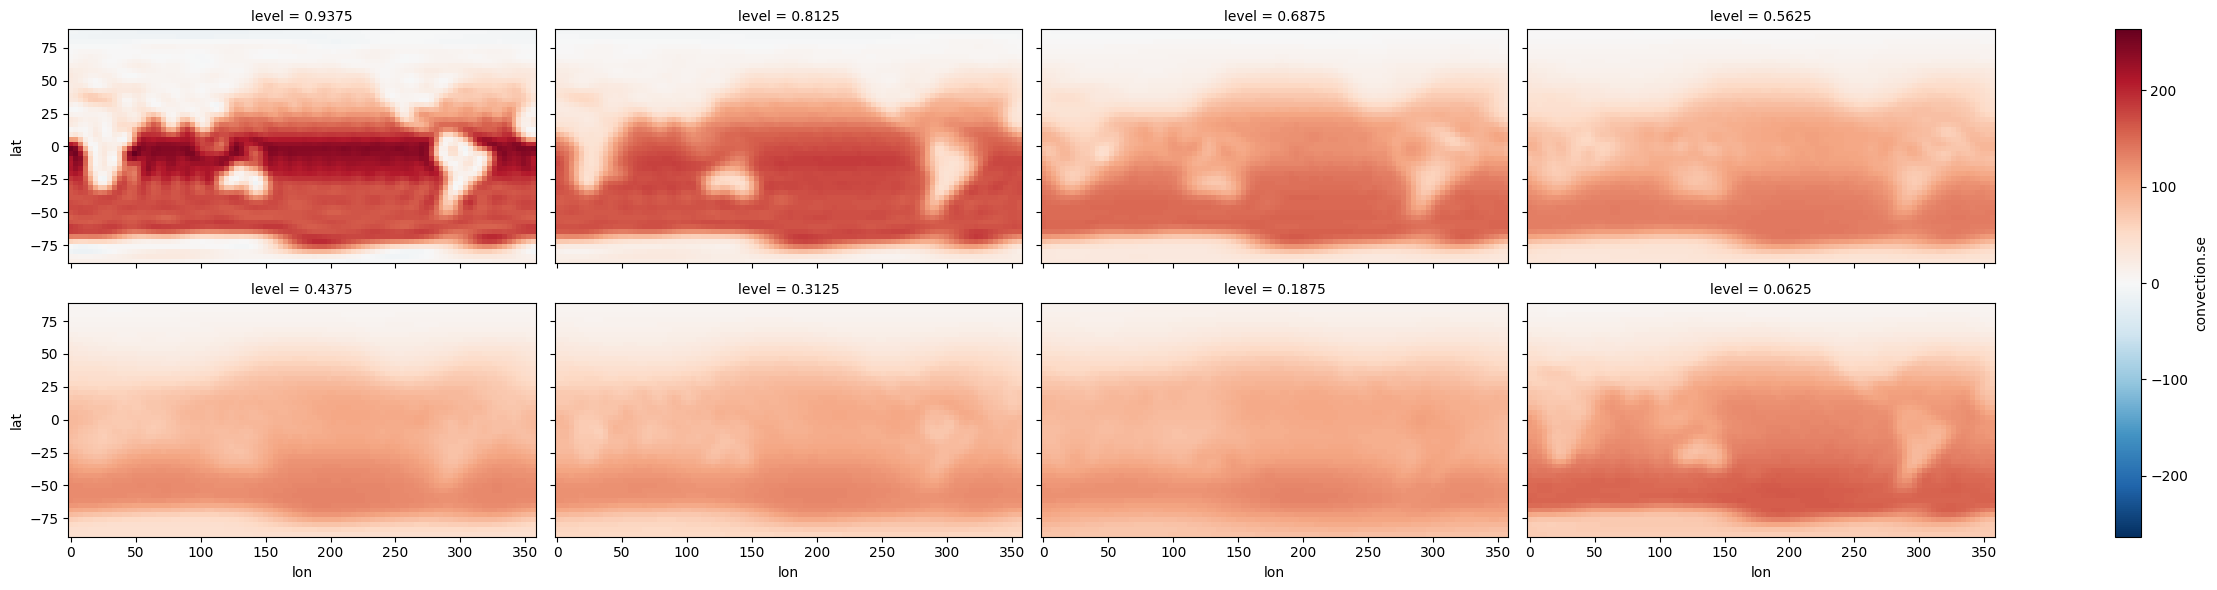

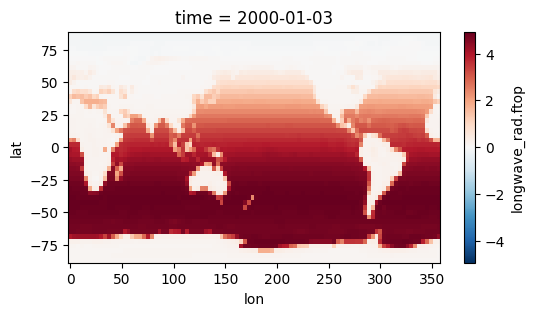

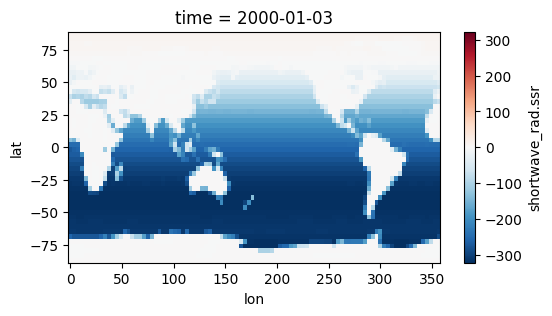

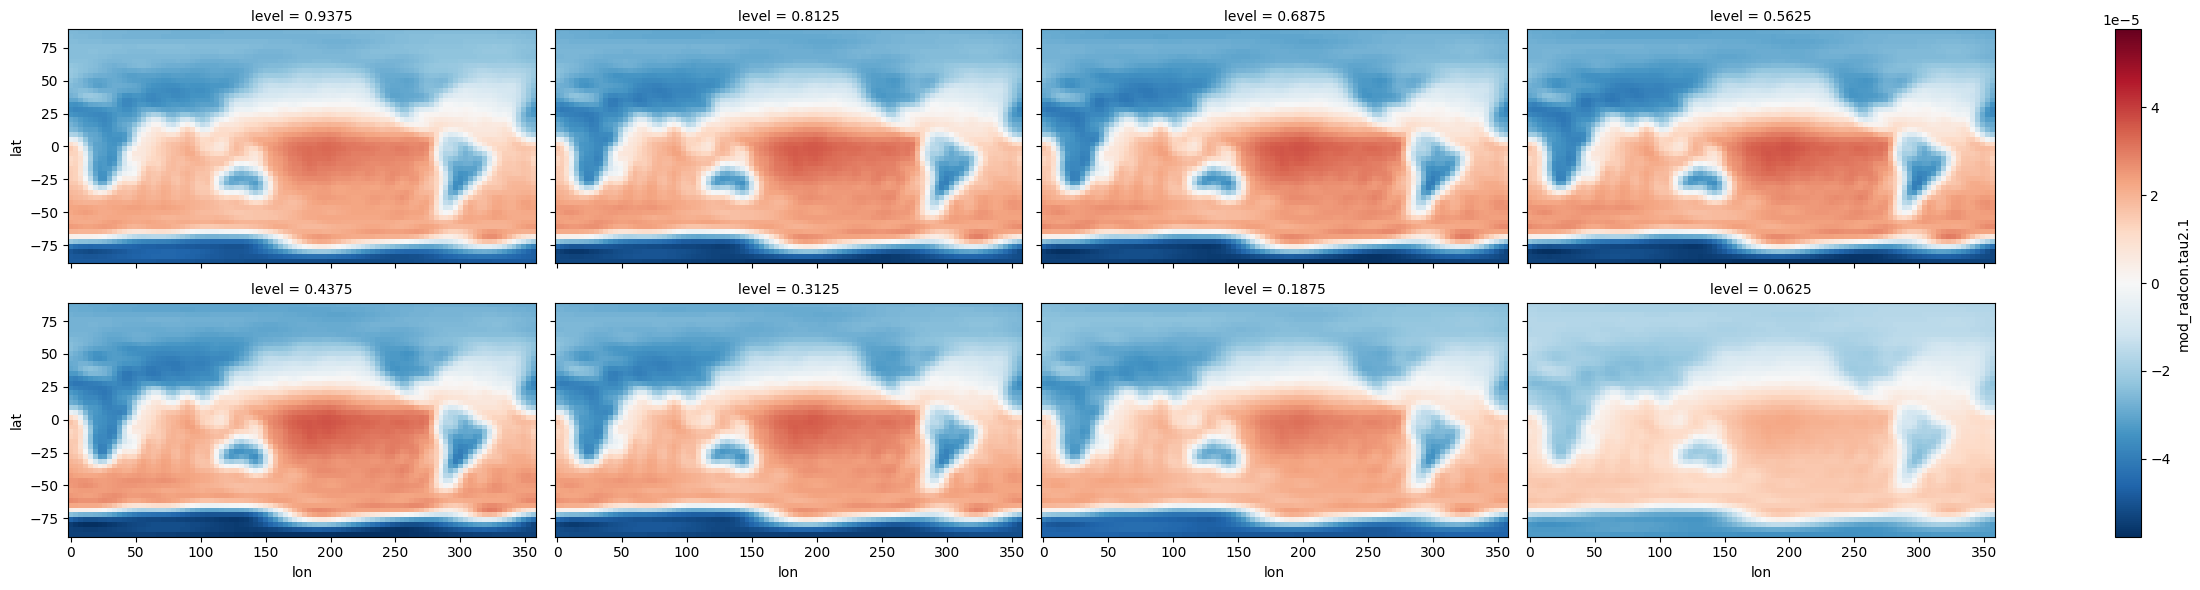

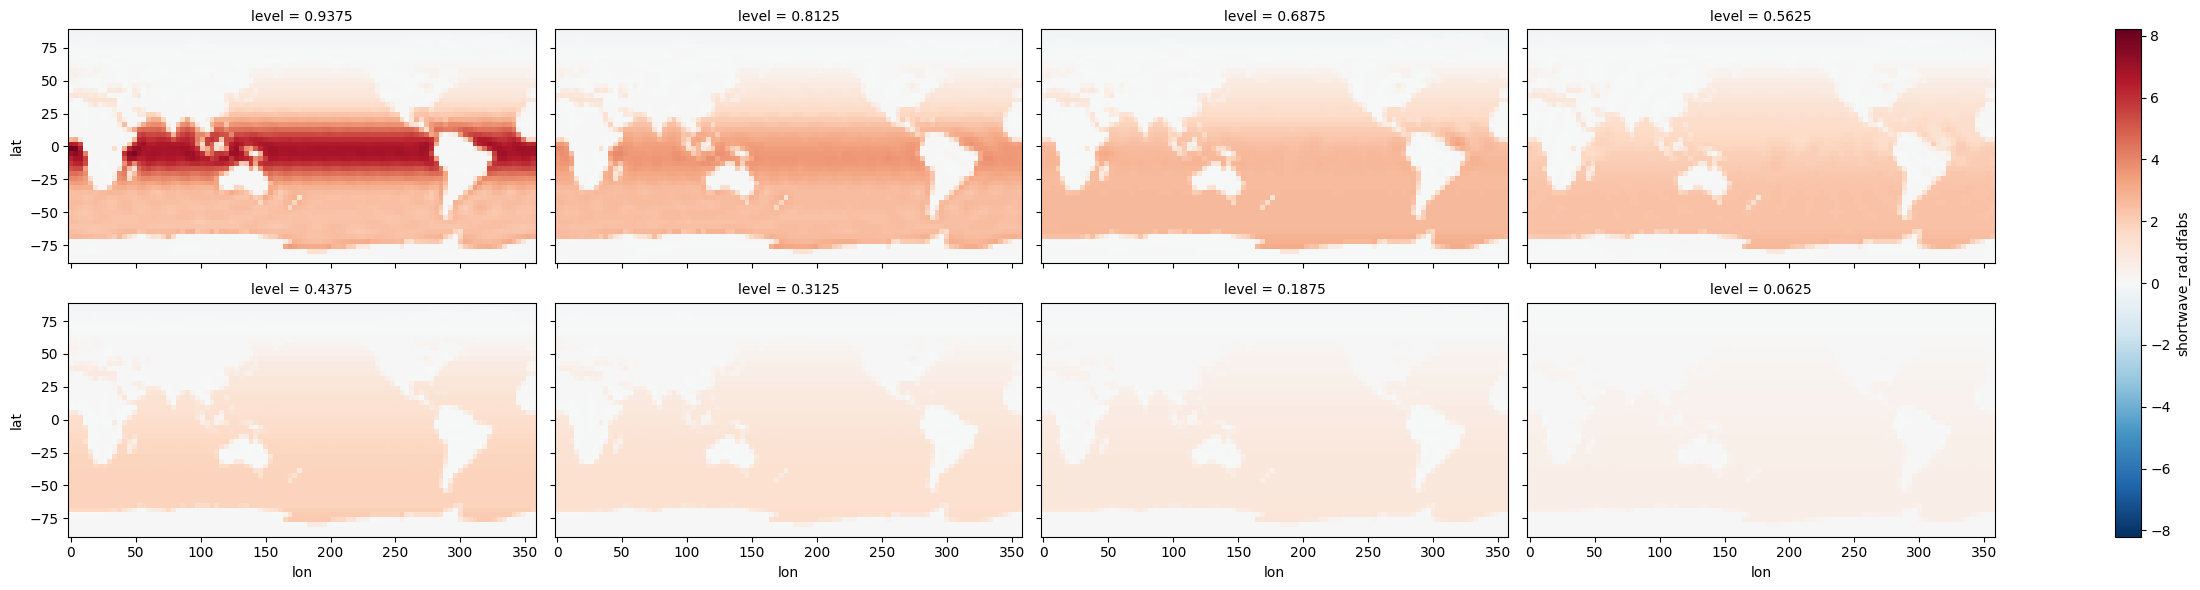

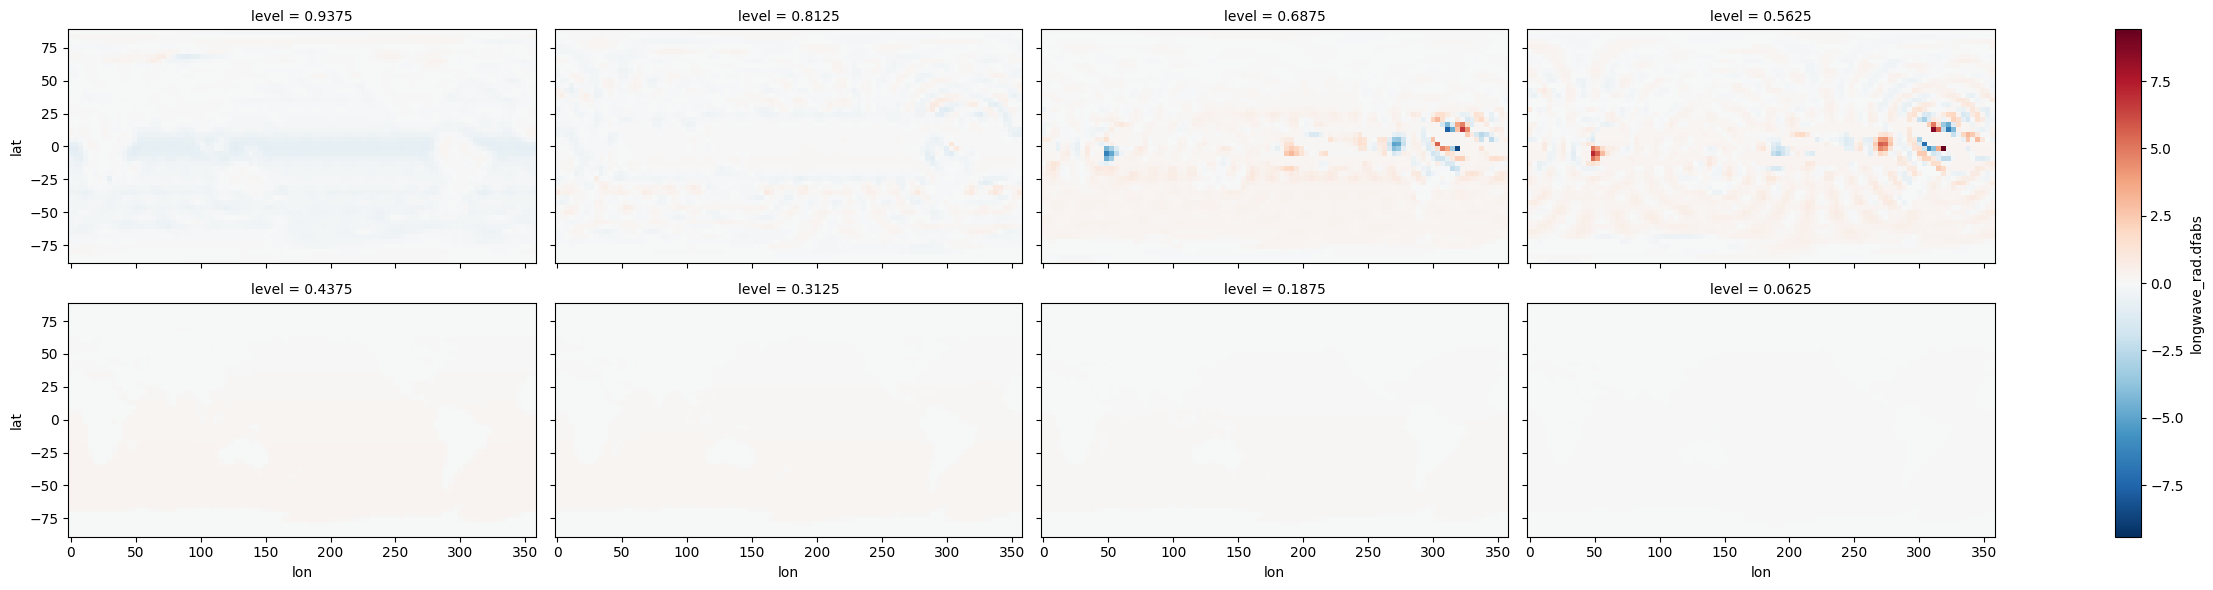

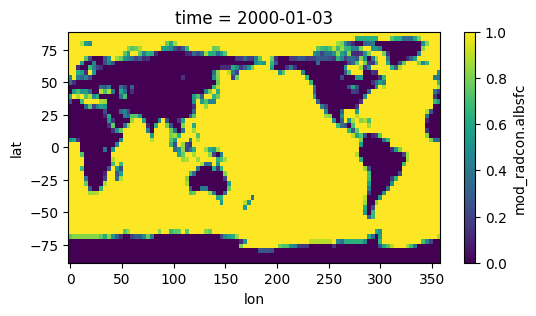

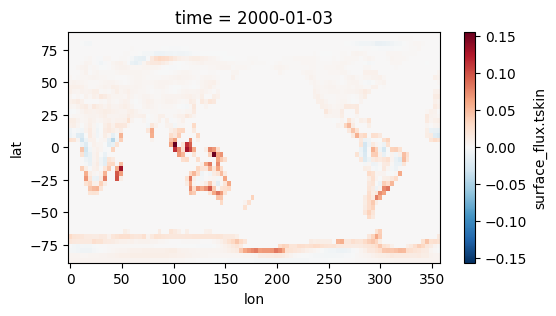

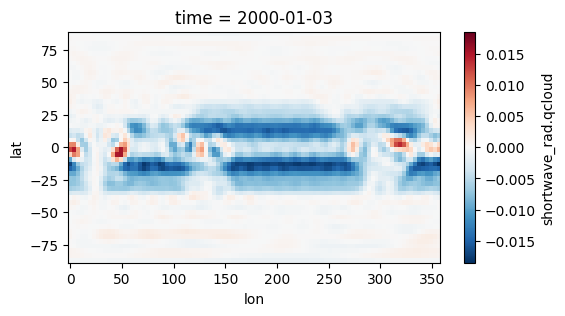

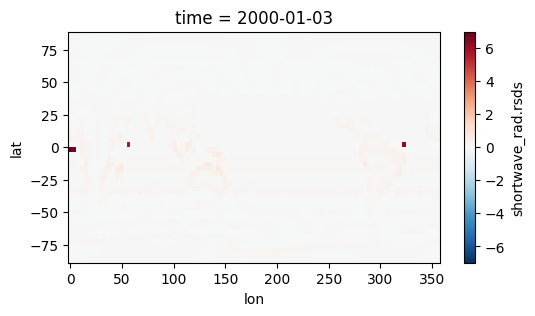

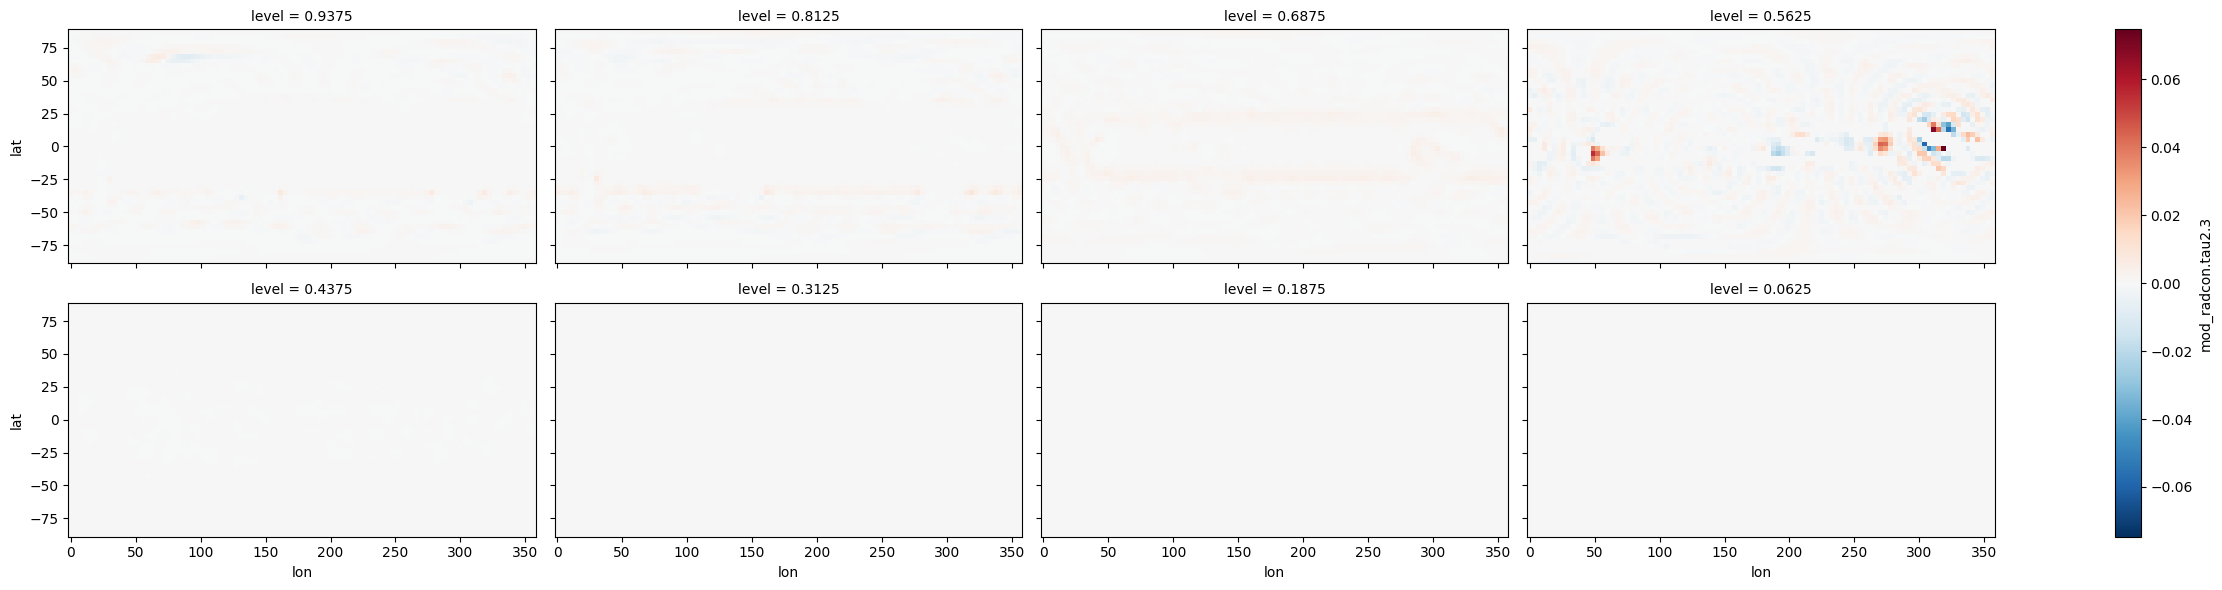

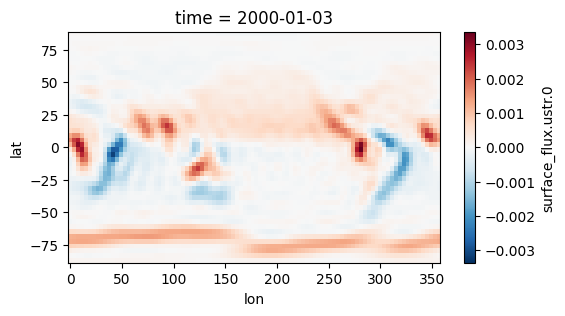

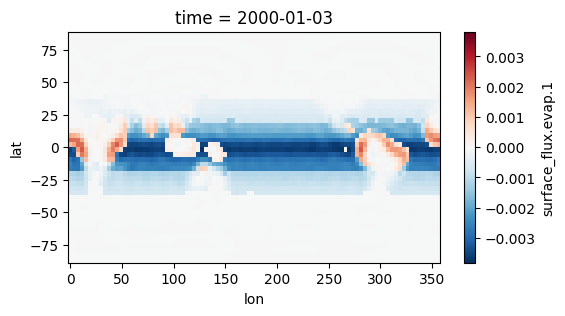

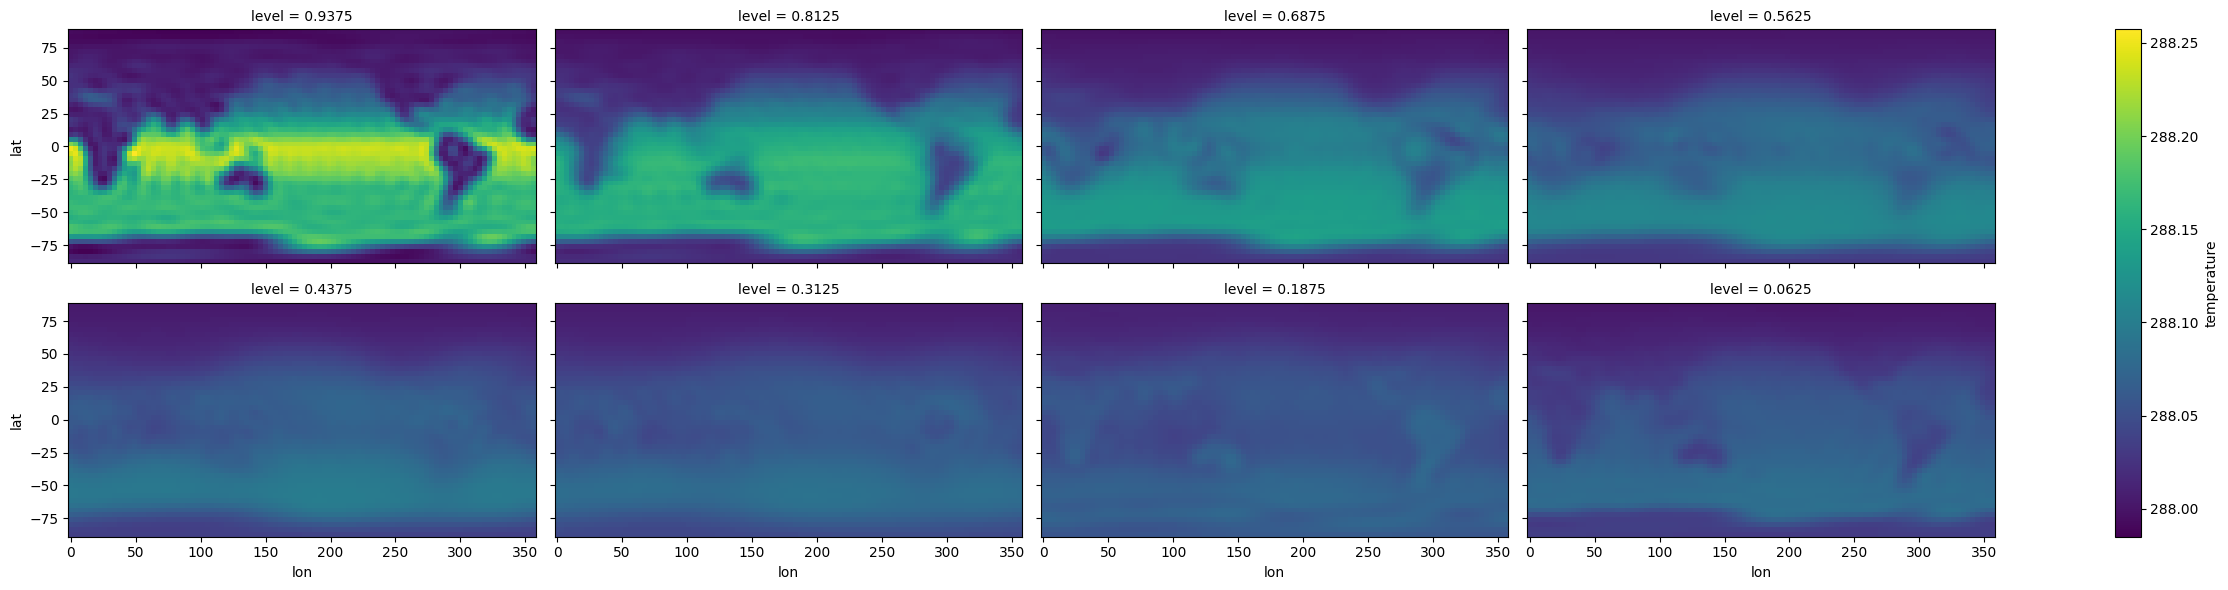

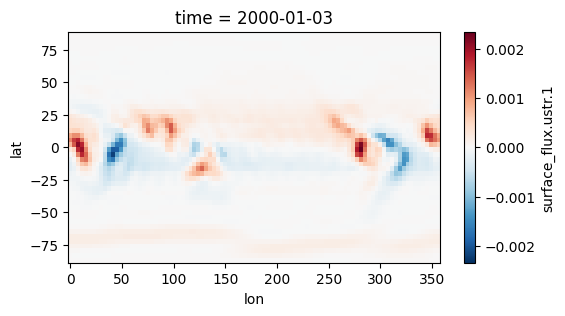

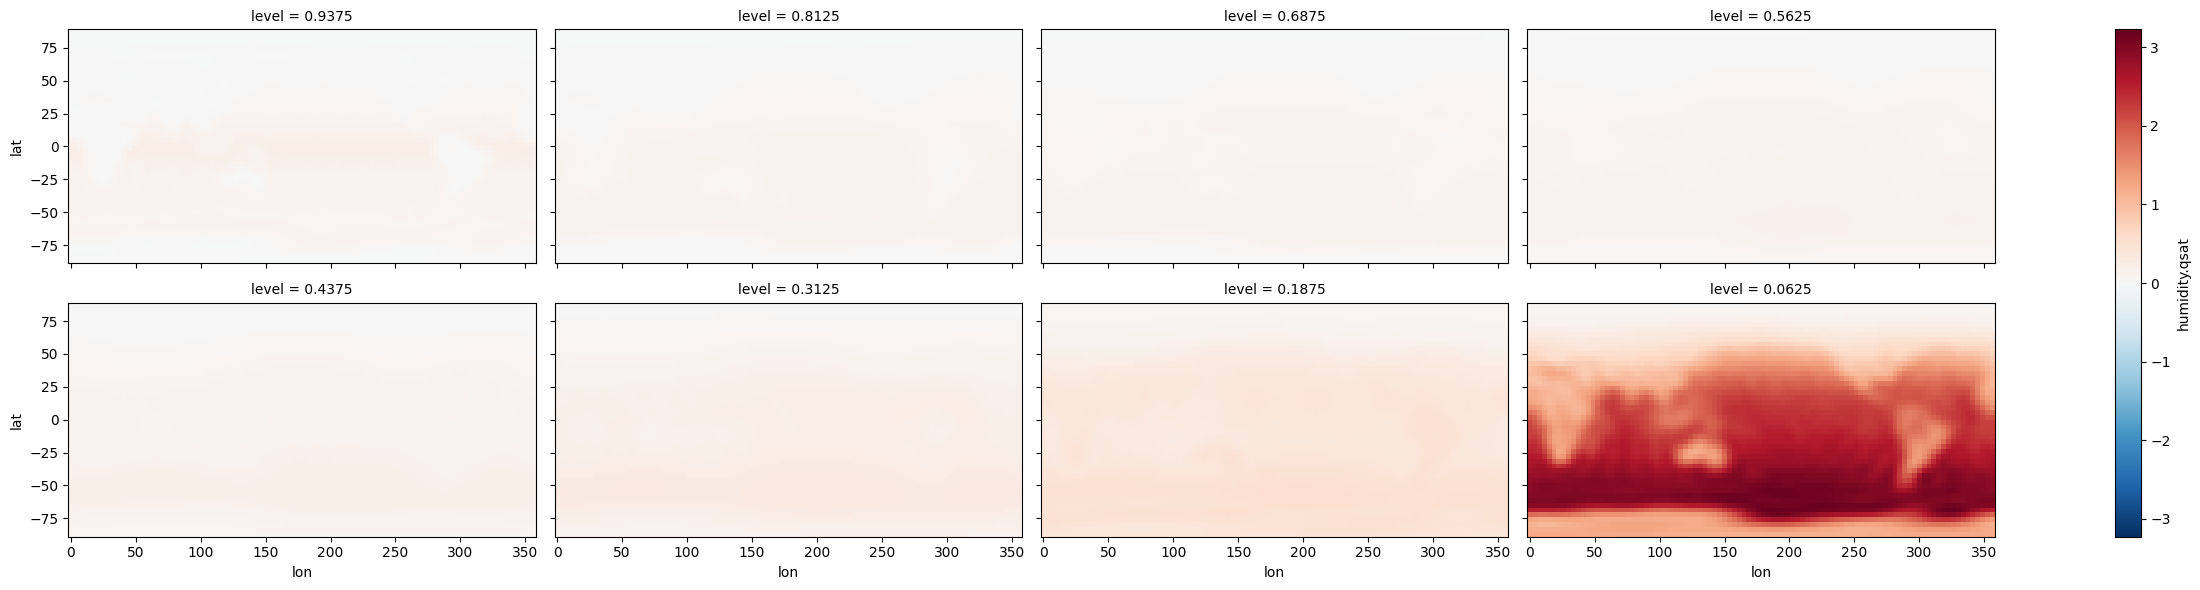

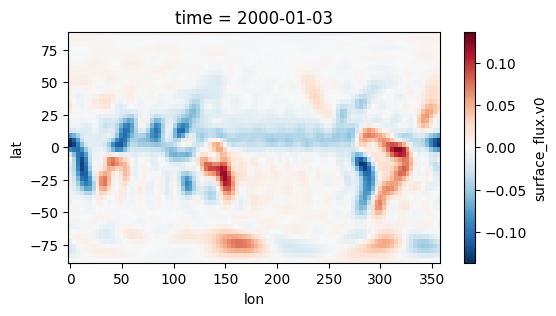

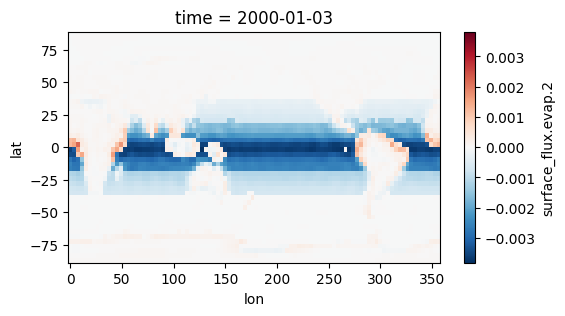

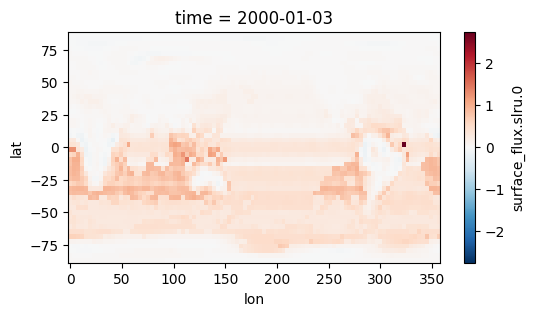

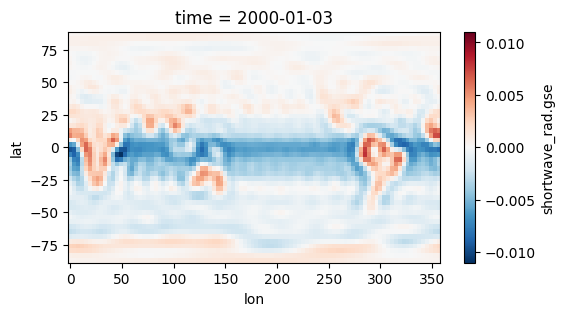

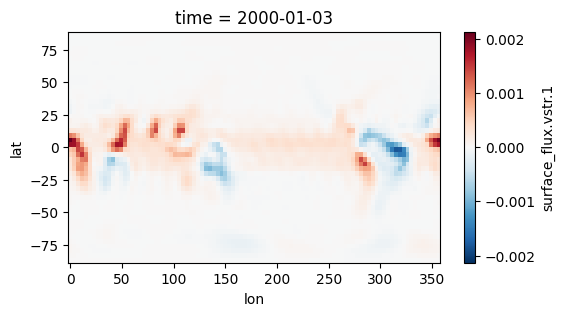

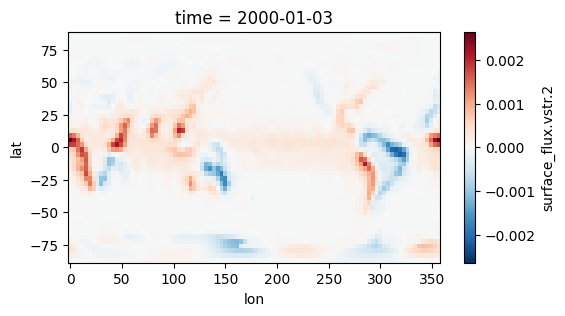

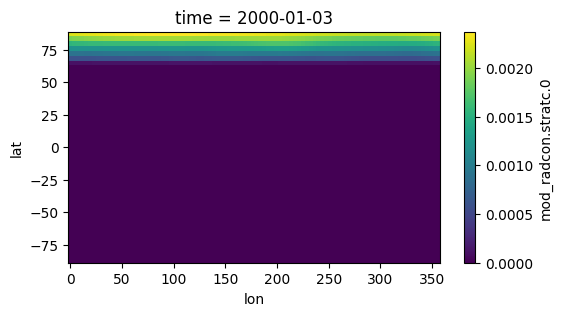

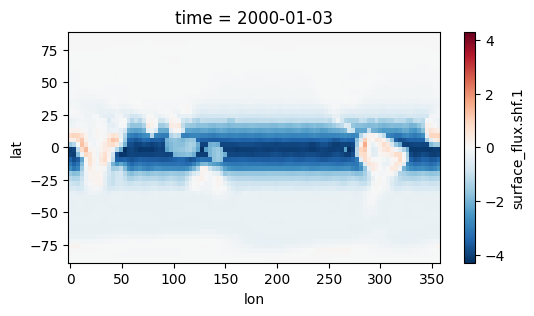

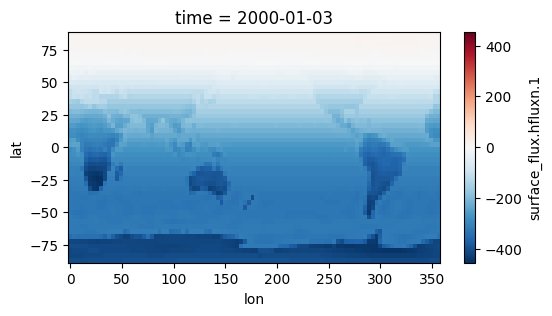

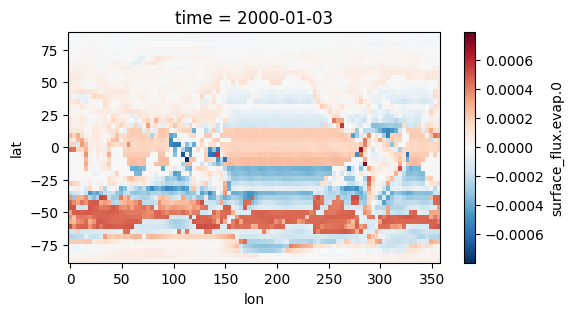

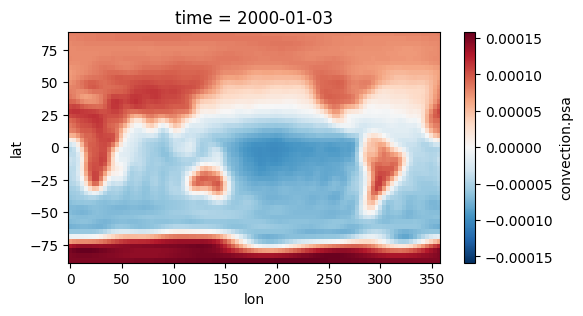

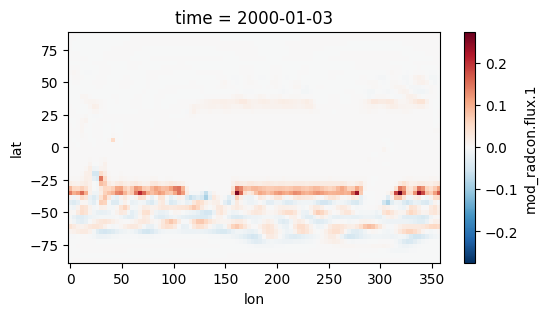

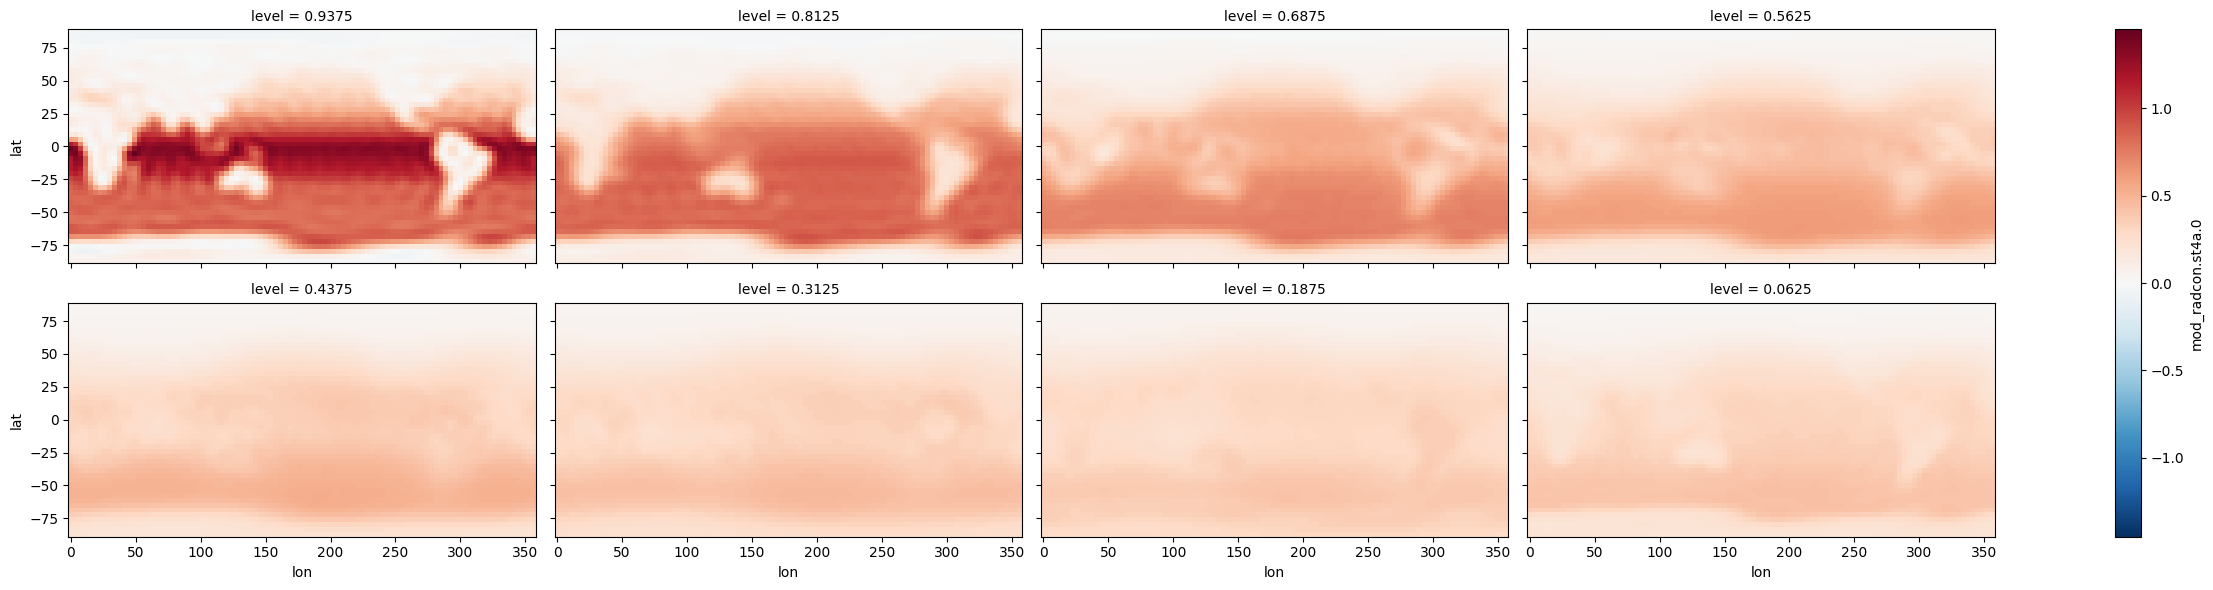

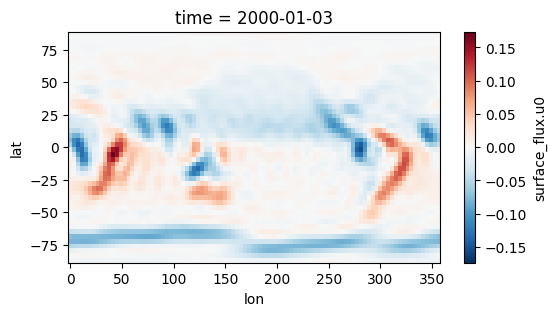

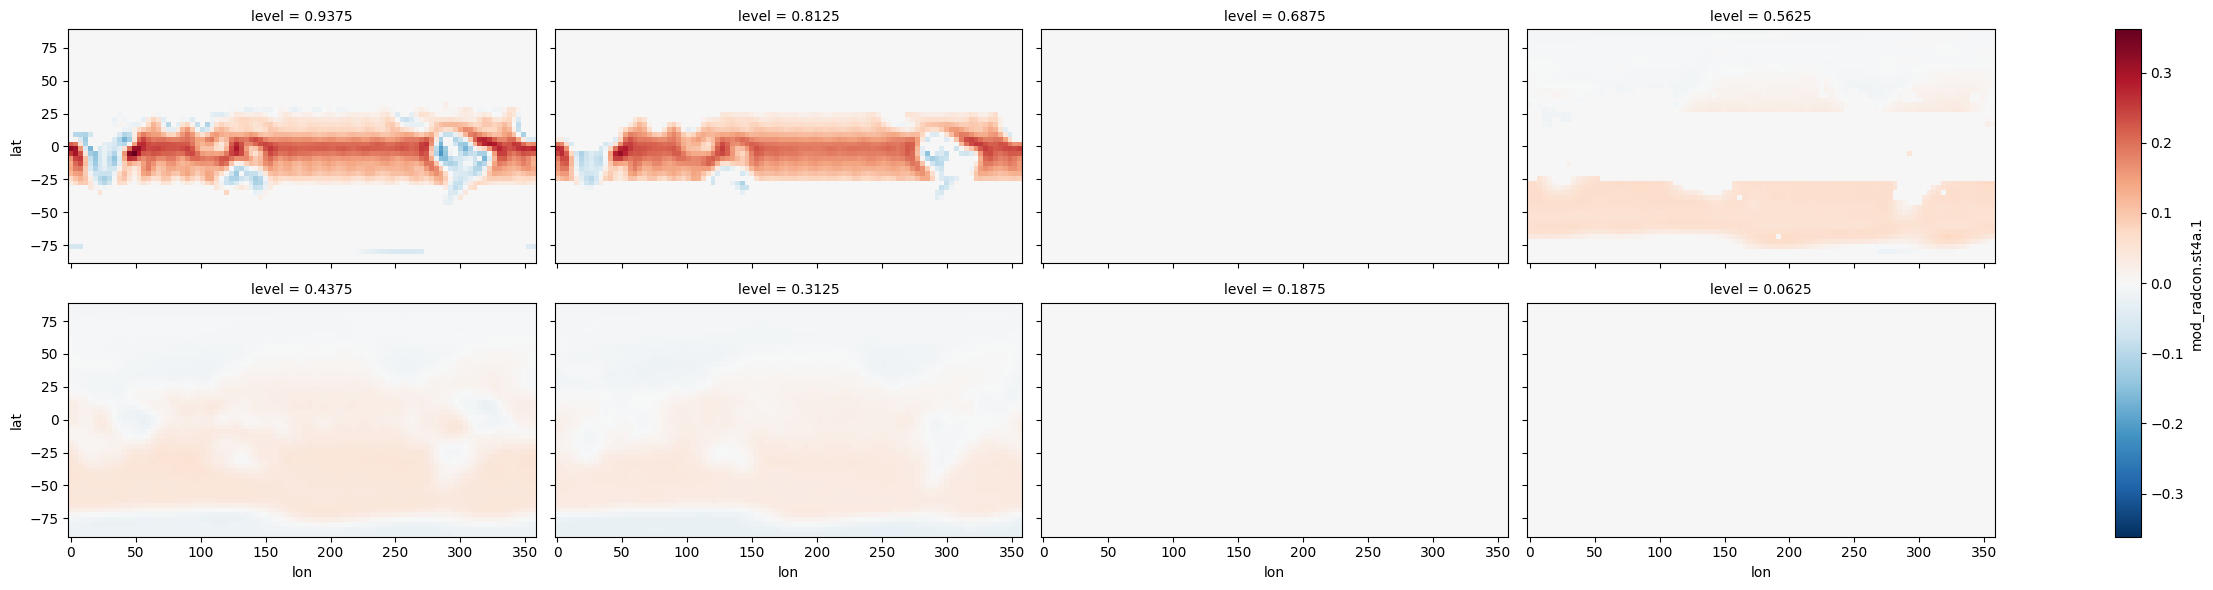

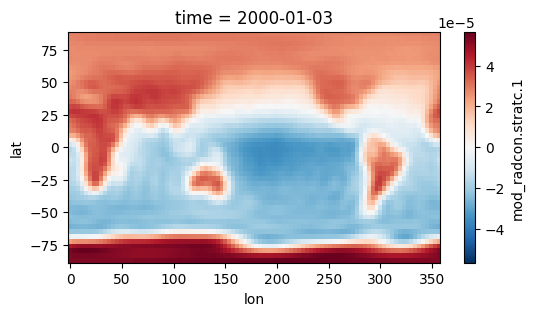

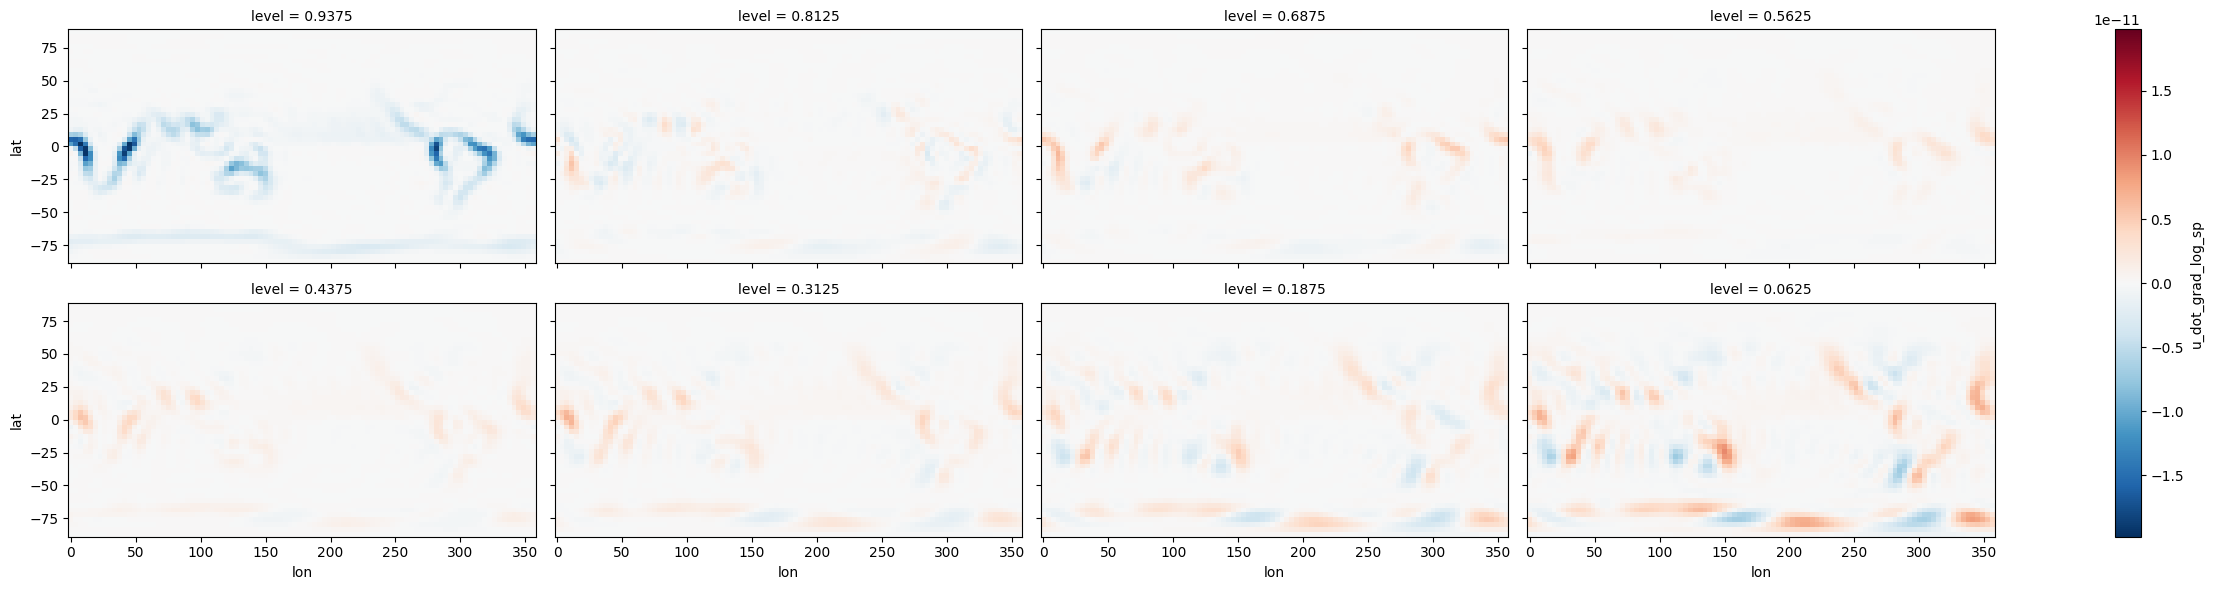

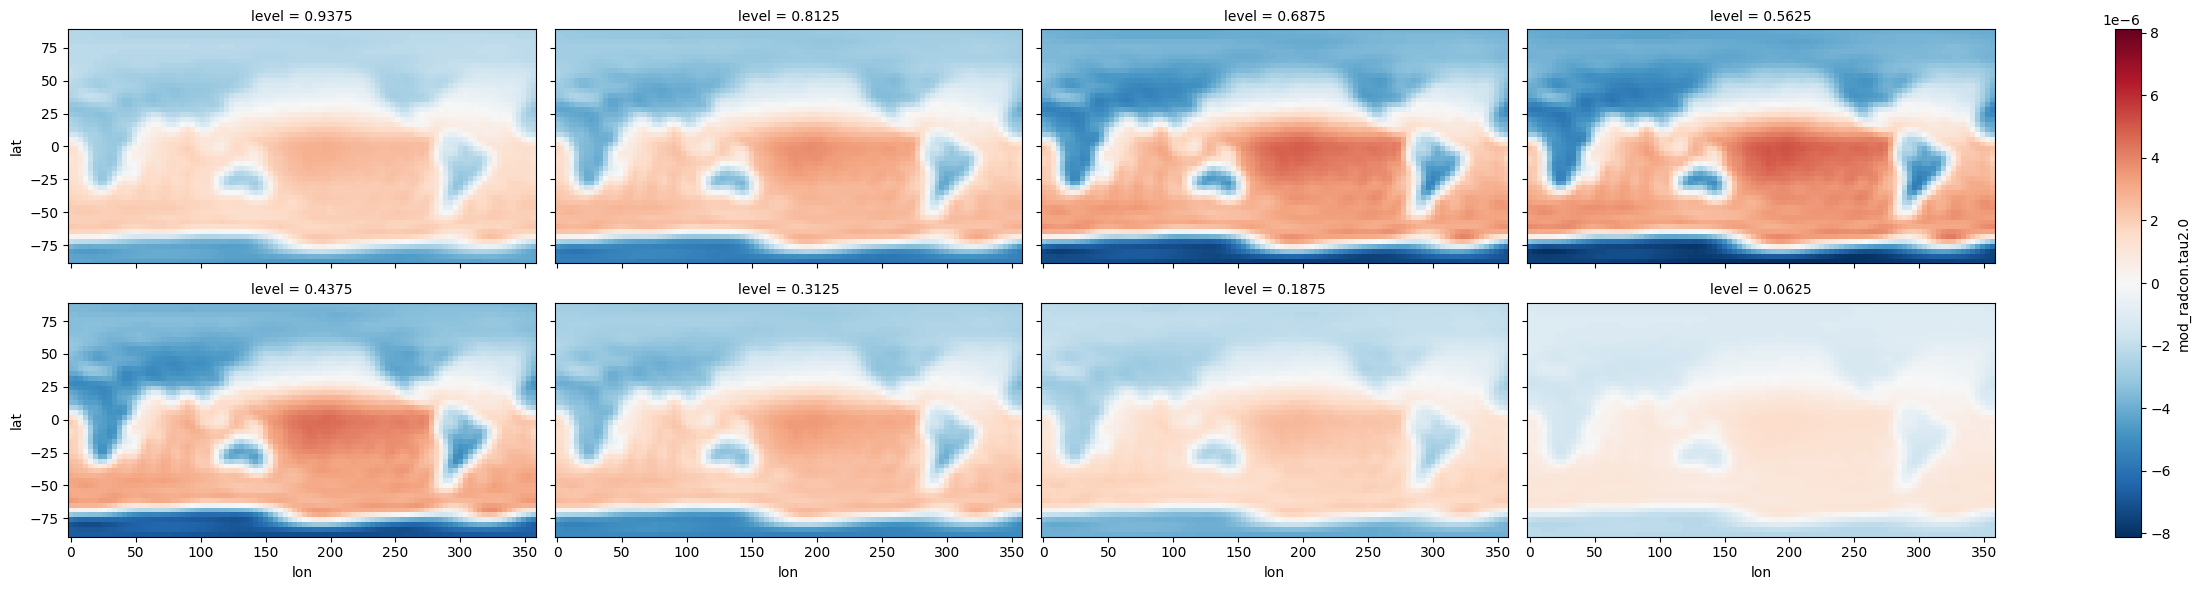

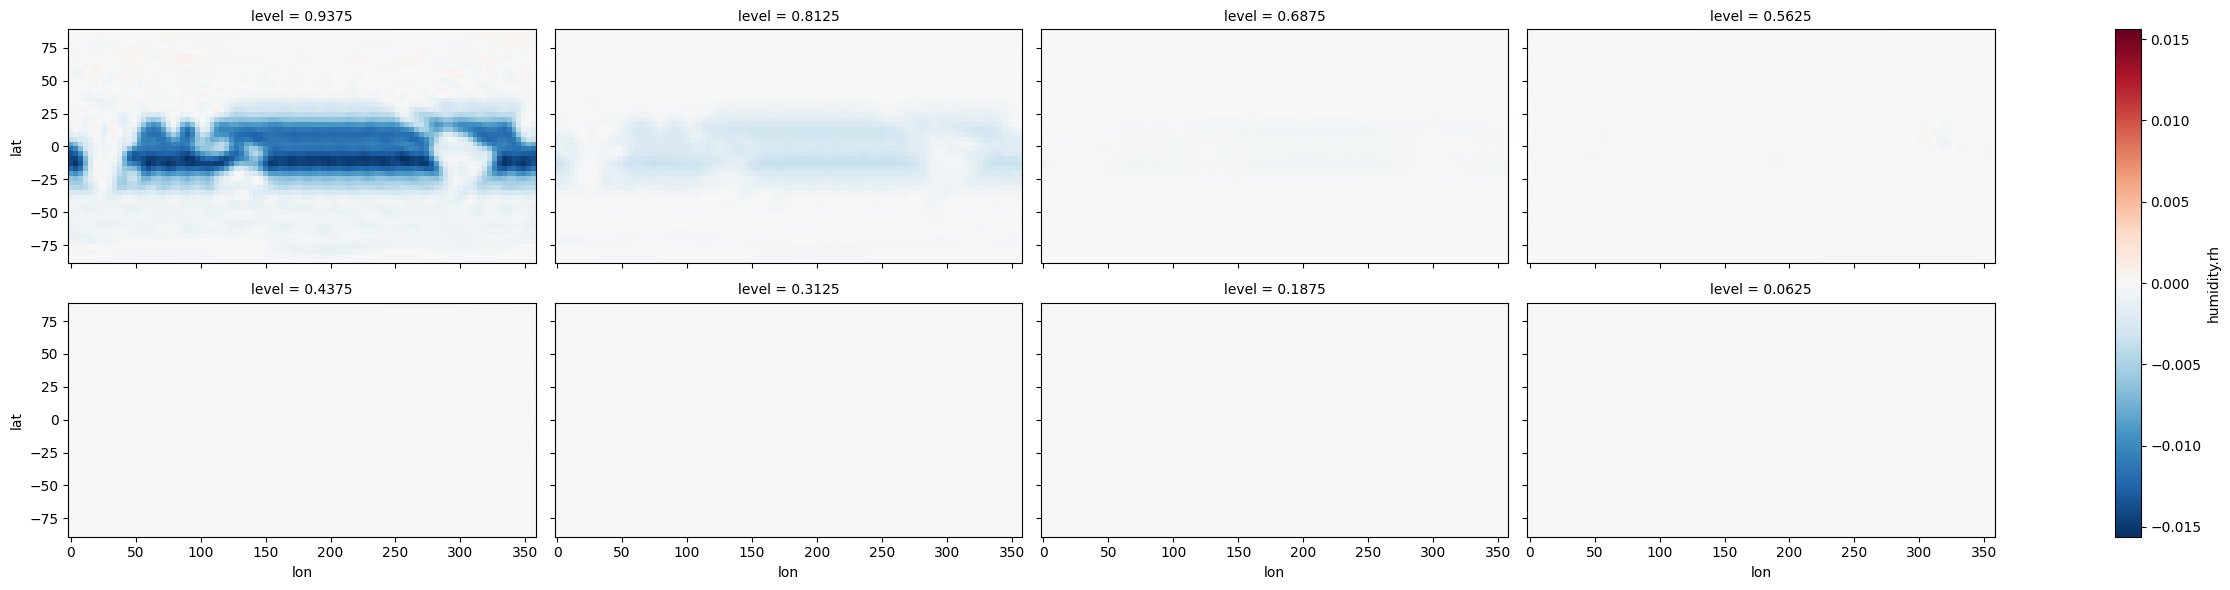

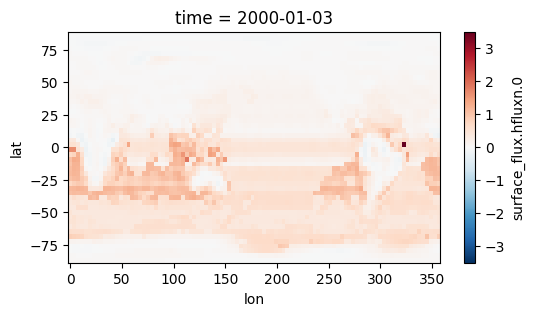

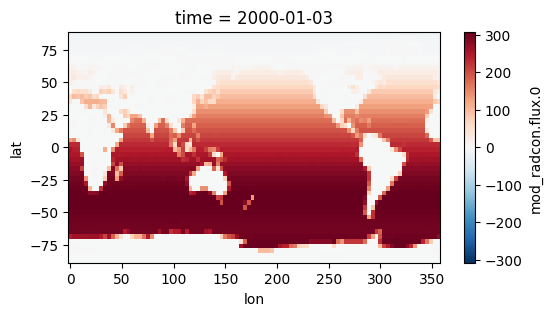

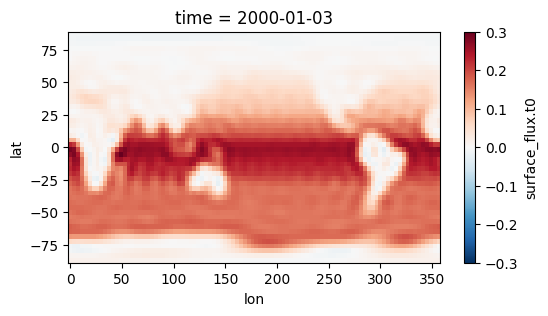

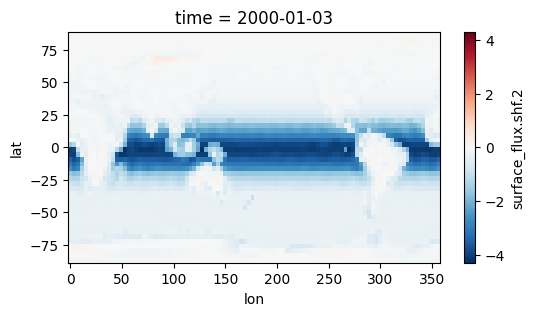

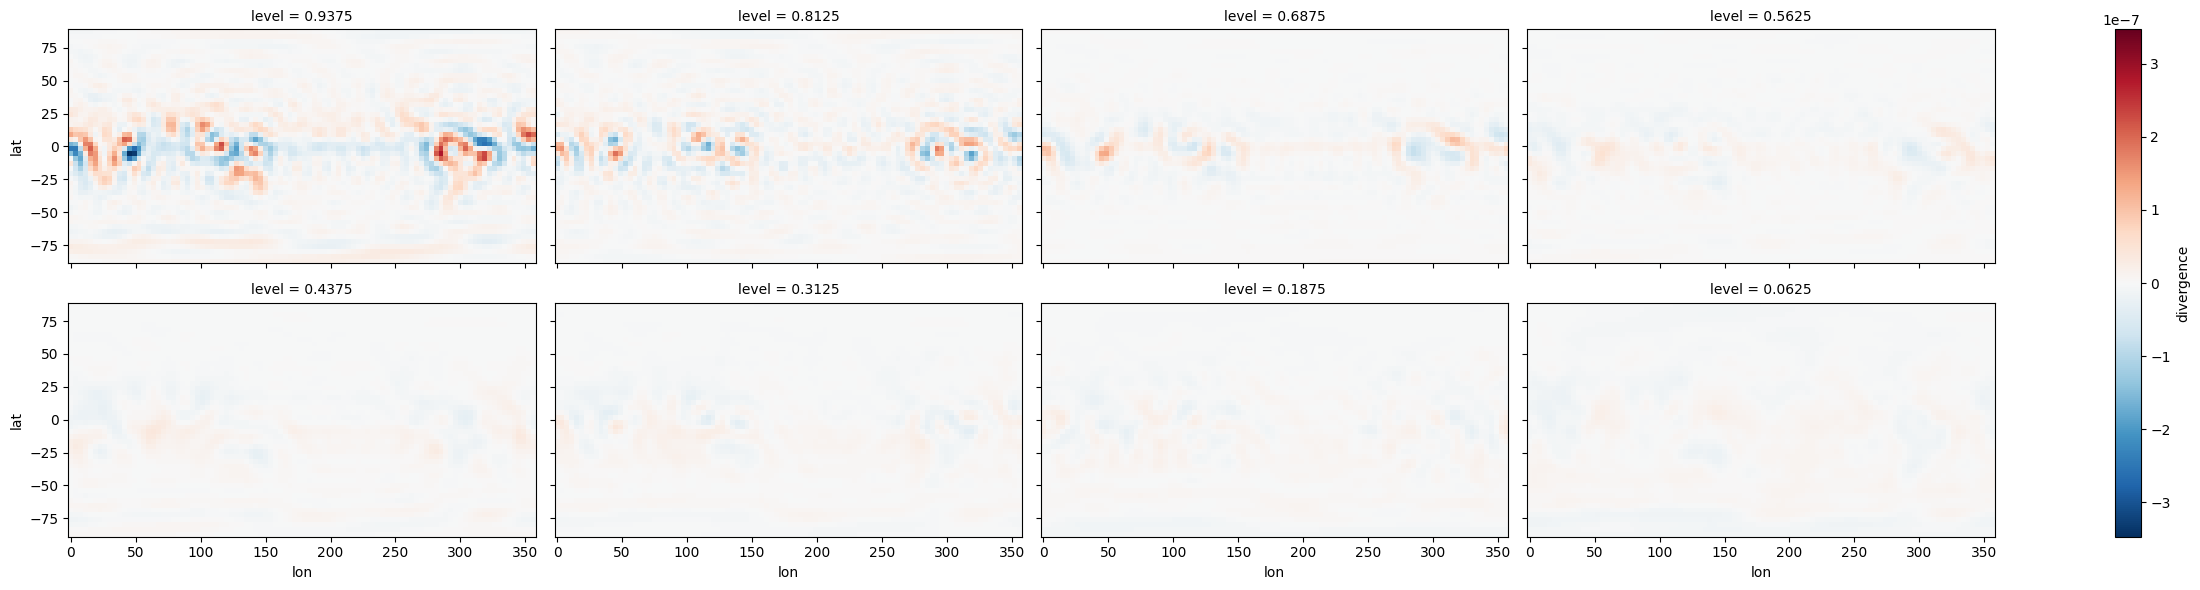

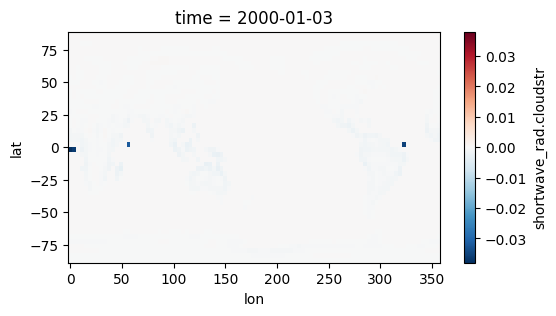

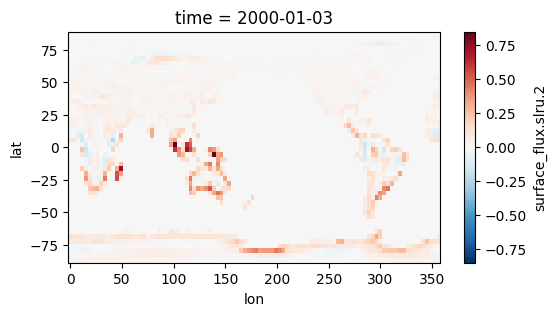

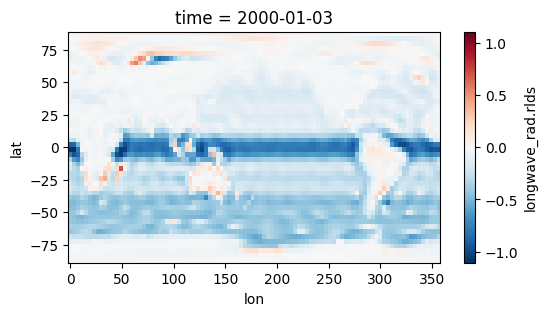

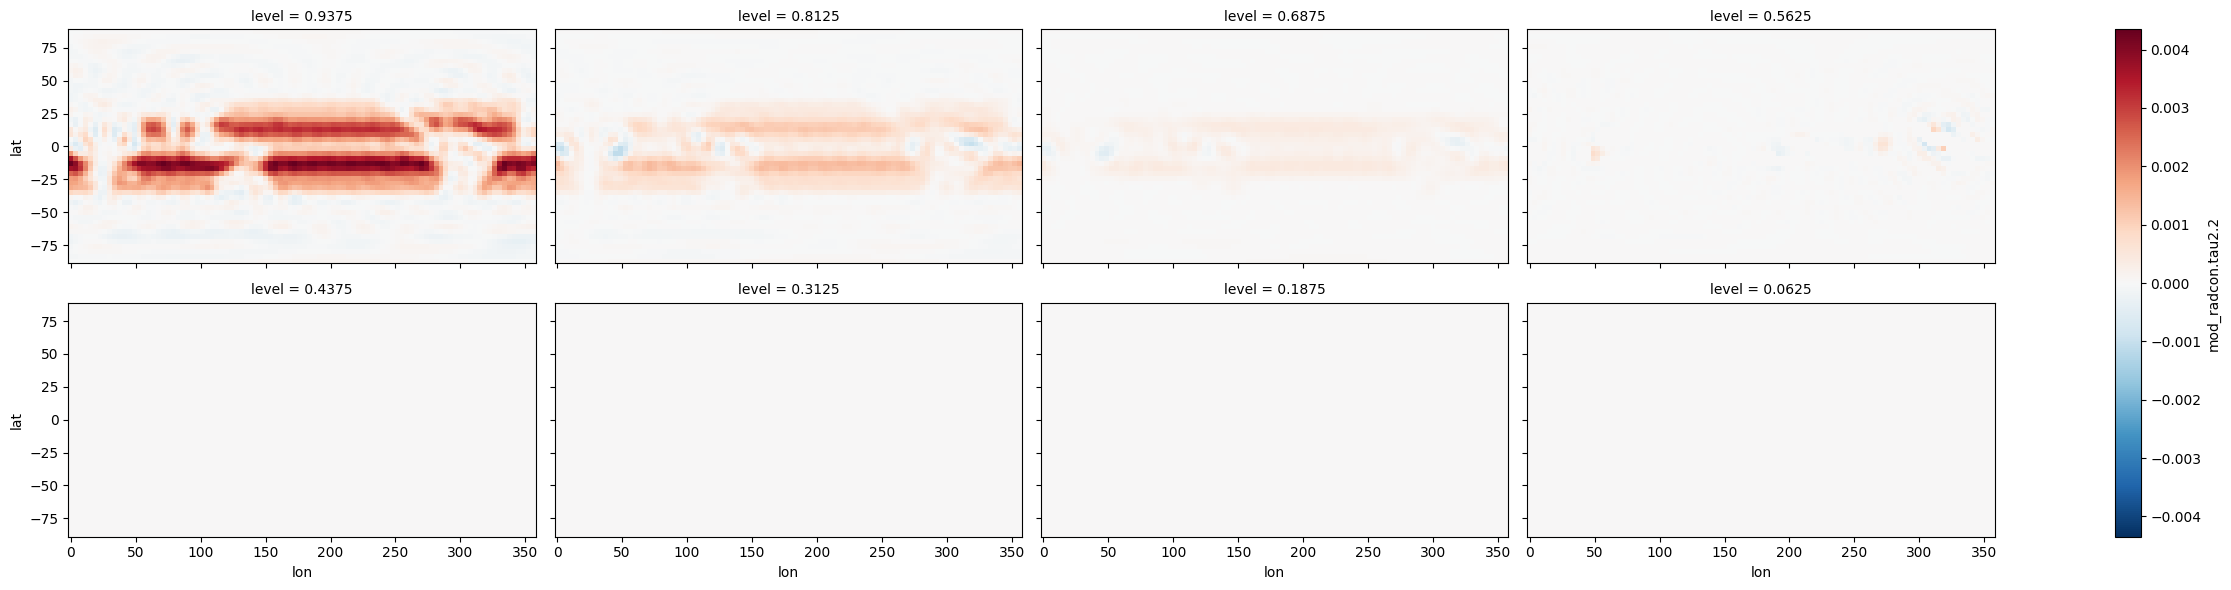

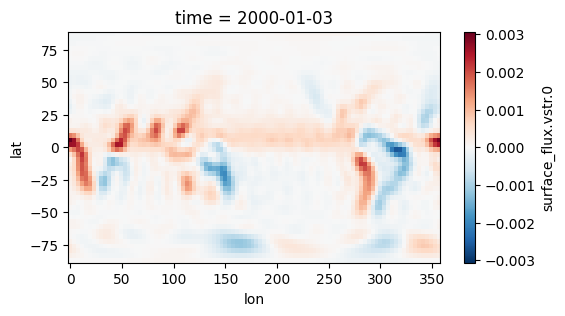

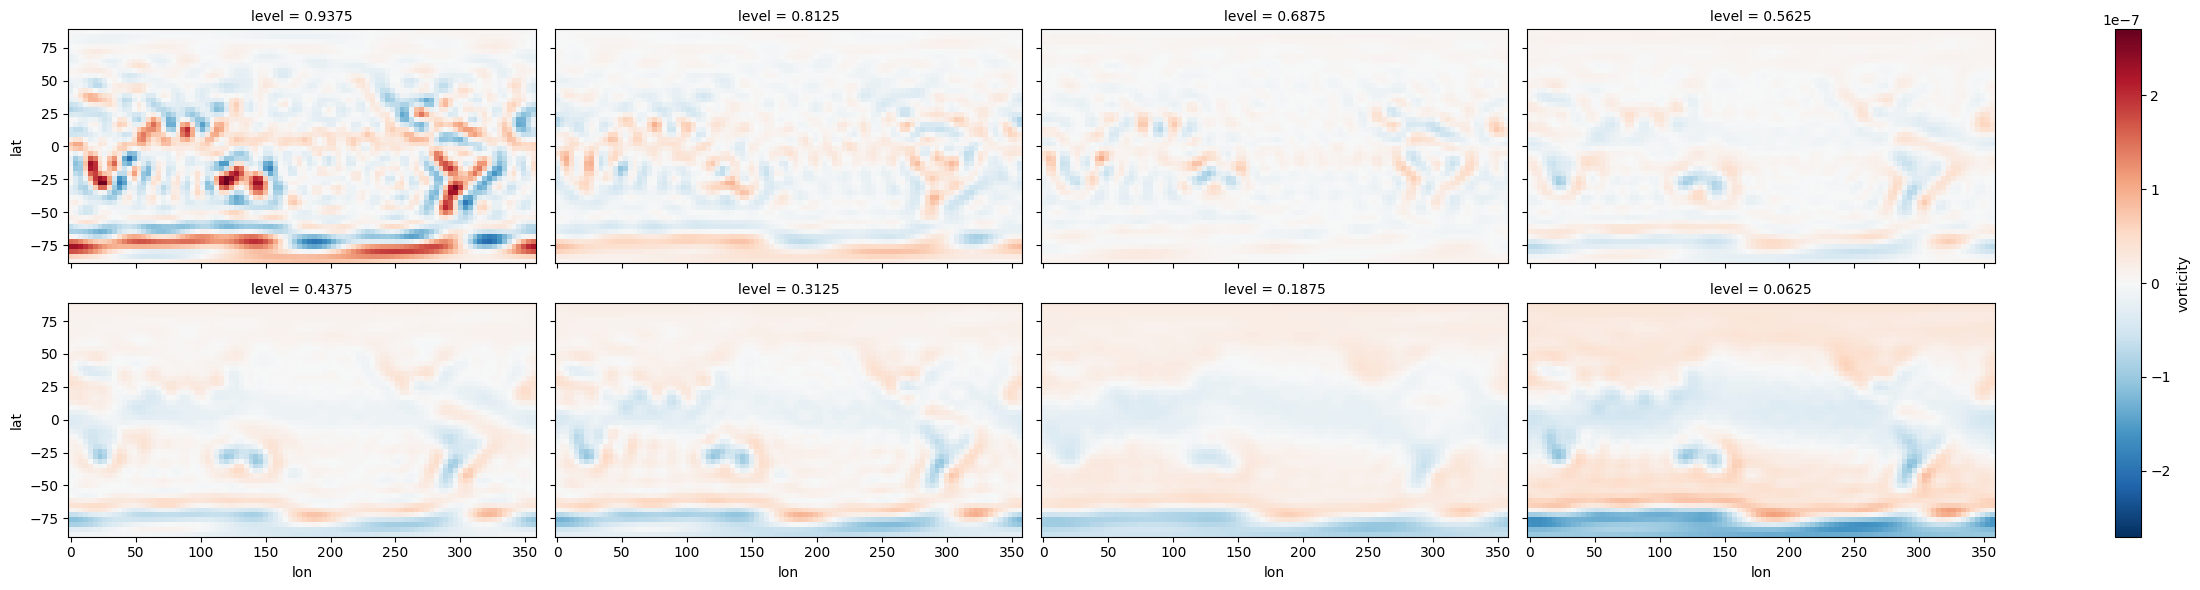

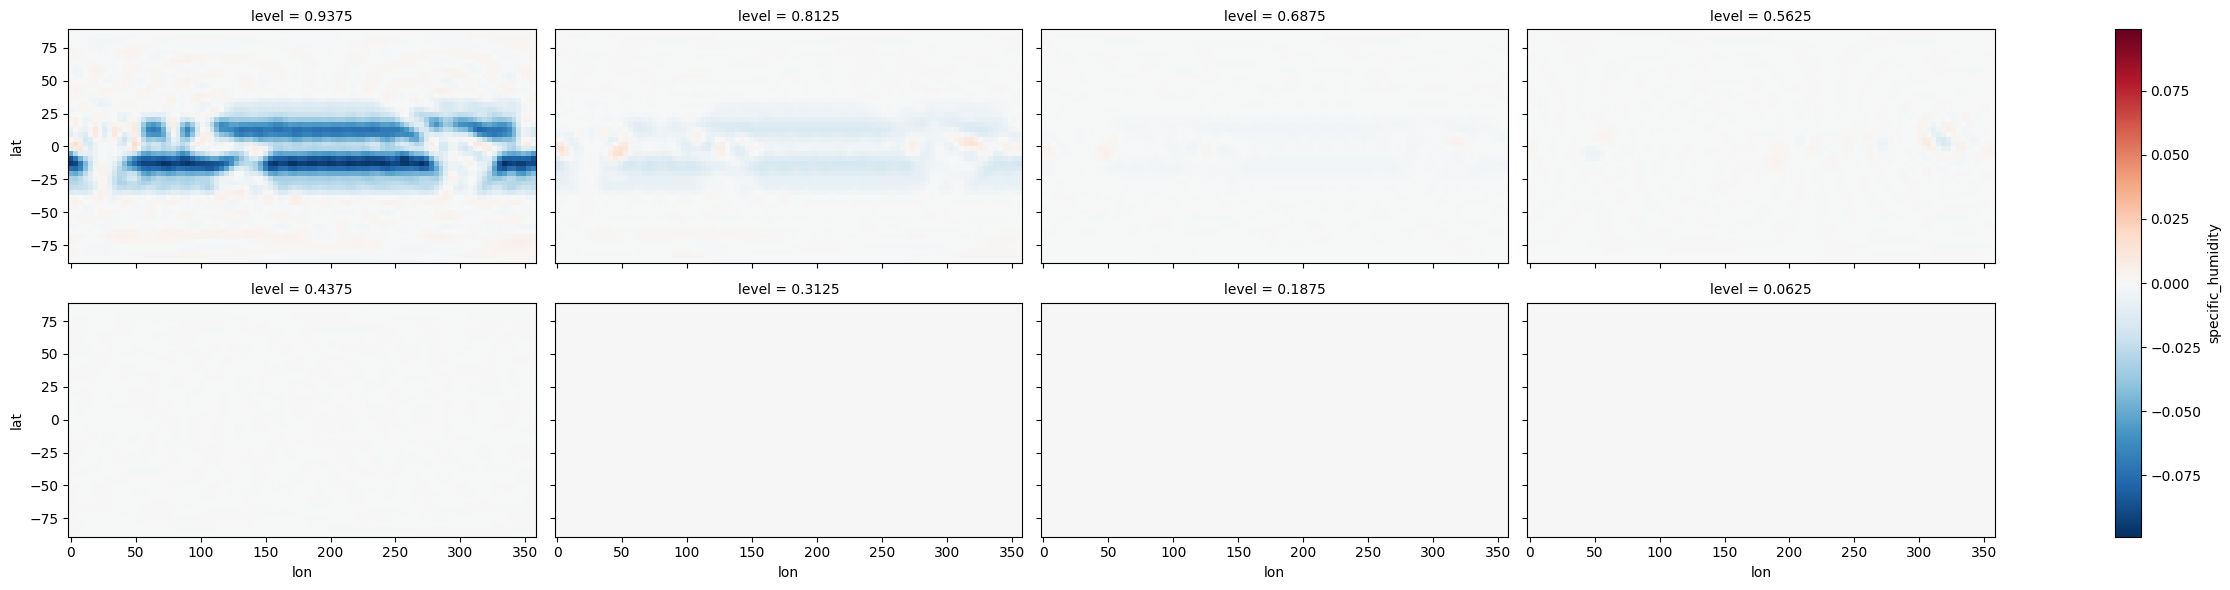

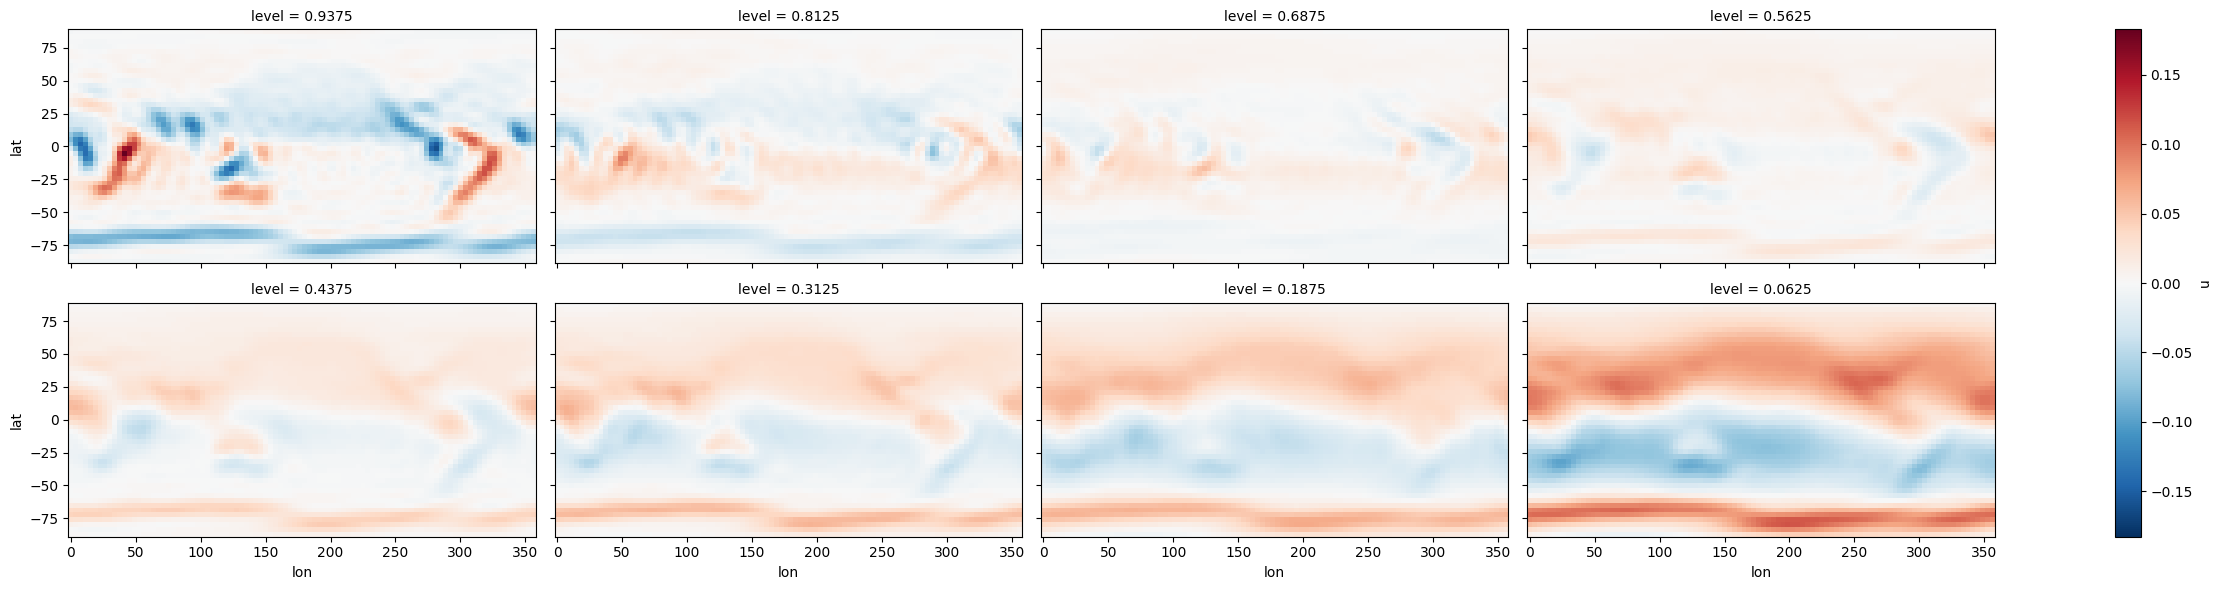

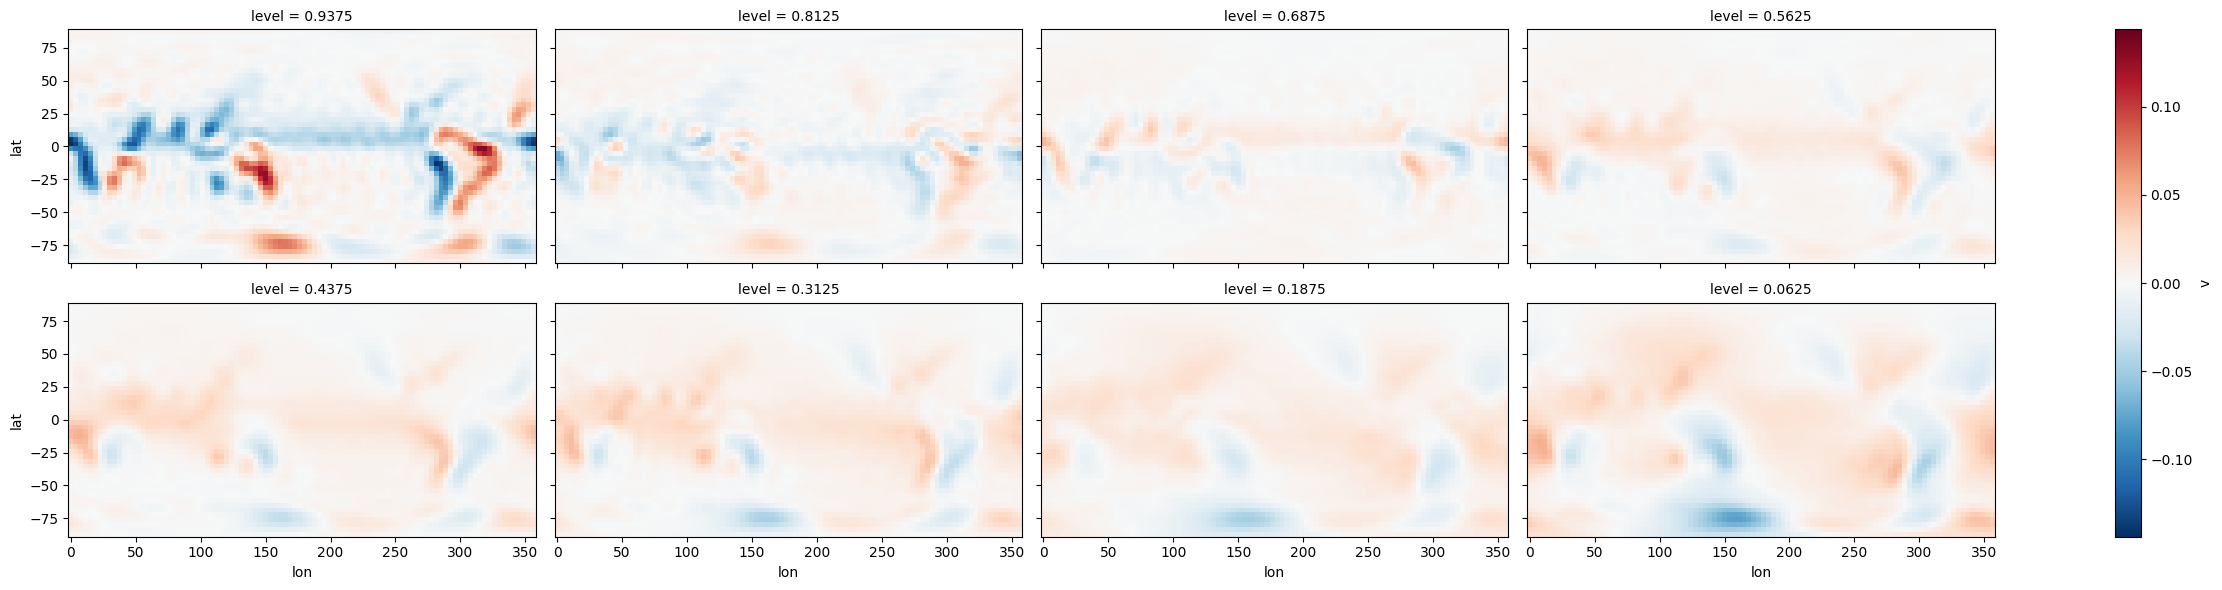

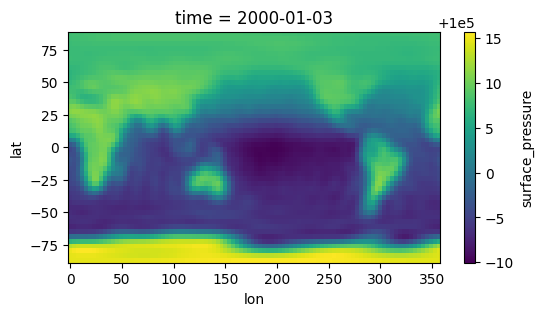

In [122]:
for v in list(grad_ds.variables):
    if v in ['mod_radcon.ablco2', 'convection.iptop', 'date.model_year', 'date.tyear', 'shortwave_rad.icltop', 'lon', 'lat', 'level', 'time']:
        continue
    data = grad_ds[v].isel(time=1)
    if np.nanmax(data) == np.nanmin(data):
        print(f"gradient of {v} is {np.nanmax(data)}")
        continue
    # data = np.log(np.abs(data))
    if 'level' in grad_ds[v].coords:
        data.plot(x='lon', y='lat', size=3, aspect=2, col='level', col_wrap=4);
    else:
        data.plot(x='lon', y='lat', size=3, aspect=2);